### Import necessary libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


### Variables

In [2]:
classes = 43

### Create model

In [3]:
def create_model(learning_rate=0.0001):
    
    base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(32, 32, 3)
    )
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(43, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = keras.optimizers.Adam(learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model


### Resize all images to 32x32 pixels

In [4]:
def resize_images(size=(32, 32)):
    for i in range(classes):
        input_directory = f"../app/data/train/{i}"
        output_directory = f"../app/data/train-r/{i}"
        
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)
    
        for filename in os.listdir(input_directory):
            input_path = os.path.join(input_directory, filename)
            output_path = os.path.join(output_directory, filename)
    
            try:
                with Image.open(input_path) as img:
                    img = img.resize(size)
                    img.save(output_path)
                    print(f"Resized and saved: {output_path}")
            except Exception as e:
                print(f"Error processing {input_path}: {e}")

In [ ]:
resize_images(size=(32, 32))

### Load train images

In [5]:
def load_images():
    
    sign_images = []
    sign_indexes = []

    for i in range(classes):
        
        input_directory = f"../app/data/train-r/{i}"
        
        for filename in os.listdir(input_directory):
            input_path = os.path.join(input_directory, filename)

            try:
                with Image.open(input_path) as img:
                    sign_images.append(np.array(img))
                    sign_indexes.append(i)
            except Exception as e:
                print(f"Error processing {input_path}: {e}")

    sign_images = np.array(sign_images)
    sign_indexes = np.array(sign_indexes)

    return sign_images, sign_indexes

In [7]:
sign_images, sign_indexes = load_images()

### Split train images

In [8]:
X_train, X_val, y_train, y_val = train_test_split(sign_images, sign_indexes, test_size=0.2, random_state=42)

In [9]:
y_train = keras.utils.to_categorical(y_train, classes)
y_val = keras.utils.to_categorical(y_val, classes)

### Train model

In [ ]:
model = create_model(learning_rate=0.1)

In [ ]:
model.describe()

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint (
    "../checkpoints/traffic_sign_classification_resnet50_lr1_{epoch:02d}_{val_accuracy:.3f}.h5",
    save_best_only=True,
    monitor="val_accuracy"
)

history = model.fit(X_train,y_train,
                    validation_data=(X_val, y_val),
                    epochs=35, batch_size=32, 
                    callbacks=[checkpoint])

### Plot accuracy and loss

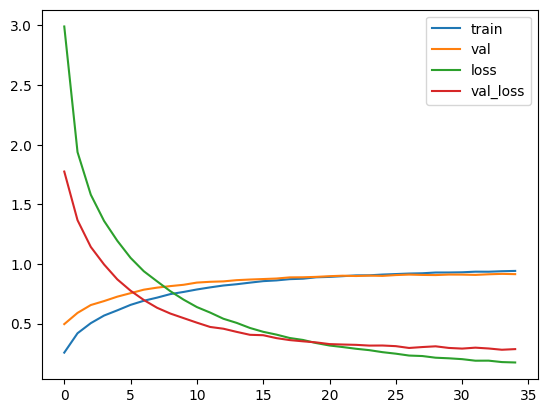

In [27]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Make predictions

In [11]:
class_descriptions = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing for vehicles over 3.5 metric tons',
    11: 'Right-of-way at the next intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Vehicles over 3.5 metric tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve to the left',
    20: 'Dangerous curve to the right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End of all speed and passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End of no passing by vehicles over 3.5 metric'
}

In [12]:
image = '../app/data/test/00001.png'

In [13]:
def make_prediction(image):
    # Load model
    model = keras.models.load_model('../checkpoints/traffic_sign_classification_resnet50_lr0001_34_0.914.h5')
    
    # Load image
    try:
        img = Image.open(image)
        img = img.resize((32,32))
        
    except Exception as e:
        print(f"Error processing {input_path}: {e}")


    # Create image matrix
    x = np.array(img)
    X = np.array([x])
    print(type(x))
    print(X.shape)
    
    # Make prediction
    pred = model.predict(X)

    # Get class info
    class_index = pred[0].argmax()
    class_name = class_descriptions[class_index]

    # Return info
    return class_index, class_name

In [14]:
class_index, class_name = make_prediction(image)

<class 'numpy.ndarray'>
(1, 32, 32, 3)
1/1 [==============================] - 1s 1s/step


In [15]:
class_index, class_name

(1, 'Speed limit (30km/h)')